# Lstm

In [1]:
# !pip install pytorch
! pip install torchmetrics
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from matplotlib import pyplot as plt
import pickle
from torchmetrics.classification import BinaryF1Score
# metric(preds, target)
from sklearn.metrics import f1_score

transform = transforms.Compose([
    transforms.ToTensor()
])



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 19.1 MB/s eta 0:00:00


In [22]:
def prepare_dataset_using_pandas(df, patient):
  """
  Create tensor dataset and label from pandas df
  """

  df_patient = df[df['id']== patient].copy(deep=True)
  df_patient.fillna(method="ffill", inplace=True)
  df_patient.fillna(method = "backfill", inplace=True)
  df_patient.fillna(0, inplace=True)
  if df_patient.shape[0]>1:
    label = df_patient['SepsisLabel'].to_list()[-1]
    # y = np.array([0]*(df_patient.shape[0]-1)+[label]).astype('float32')
  else: 
    y = np.array(df_patient['SepsisLabel'].to_list()[0]).astype('float32')
    print("strange")
  X = df_patient.drop(['id', 'SepsisLabel'], axis=1).to_numpy().astype('float32')
  return torch.tensor(X), torch.tensor(label).float()



In [24]:
# Build train and test dfs:

# TRAIN:
all_data_for_training = pd.read_parquet("/content/all_data.parquet")
df_train = all_data_for_training



# TEST:
all_data_for_testing = pd.read_parquet("/content/all_data_for_testing.parquet")
df_test = all_data_for_testing



# PICKLE TRAIN:
def build_pickle_train():
  for i, patient in enumerate(df_train["id"].unique()):
    X, y_train = prepare_dataset_using_pandas(df_train, patient)
    train_list.append((X, y_train))

  with open('train_list.pkl', 'wb') as f:
    pickle.dump(train_list, f)
    
# PICKLE TEST:
def build_pickle_test():
  for i, patient in enumerate(df_test["id"].unique()):
    X, y_train = prepare_dataset_using_pandas(df_test, patient)
    test_list.append((X, y_train))

  with open('test_list.pkl', 'wb') as f:
    pickle.dump(test_list, f)

In [25]:
train_list = []
# test_list = []
build_pickle_train()
# build_pickle_test()

In [26]:
len(train_list)

20000

In [19]:

# TRAIN UNPICKLE:
with open('/content/train_list.pkl', 'rb') as fp:
    train_list = pickle.load(fp)
    print("train_list loaded successfully")

# TEST UNPICKLE:

with open('/content/test_list.pkl', 'rb') as fp:
    test_list = pickle.load(fp)
    print("test_list loaded successfully")


train_list loaded successfully
test_list loaded successfully


In [45]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=40, hidden_size=250, num_layers=1, batch_first=True)
        self.linear = nn.Linear(250, 1)
        self.sigmoid = nn.Sigmoid()
        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        # x = self.dropout(x)
        x = self.sigmoid(x)

        return x

class Model150(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=40, hidden_size=150, num_layers=1, batch_first=True)
        self.linear = nn.Linear(150, 1)
        self.sigmoid = nn.Sigmoid()
        # self.dropout = nn.Dropout(0.5)

 
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        # x = self.dropout(x)
        x = self.sigmoid(x)
        return x

class Model300(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=40, hidden_size=300, num_layers=1, batch_first=True)
        self.linear = nn.Linear(300, 1)
        self.sigmoid = nn.Sigmoid()
        # self.dropout = nn.Dropout(0.5)
 
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        # x = self.dropout(x)
        x = self.sigmoid(x)
        return x

class Model_2layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=40, hidden_size=250, num_layers=2, batch_first=True)
        self.linear = nn.Linear(250, 1)
        self.sigmoid = nn.Sigmoid()
        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        # x = self.dropout(x)
        x = self.sigmoid(x)
        return x


class Model_3layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=40, hidden_size=250, num_layers=3, batch_first=True)
        self.linear = nn.Linear(250, 1)
        self.sigmoid = nn.Sigmoid()
        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        # x = self.dropout(x)
        x = self.sigmoid(x)
        return x

# #Load Model
# model = Model()
# model.load_state_dict(torch.load('/content/model.pt'), strict=False)


In [59]:
def run_training(model):

  learning_rate = 1e-3
  optimizer = optim.Adam(model.parameters(),lr=learning_rate)   
  train_stats = []
  test_stats = []

  for epoch in range(n_epochs):
      print("Epoch :",epoch)
      # Train model: -------------------------------------------------------------
      counter =1
      model.train()
      for i, patient in enumerate(train_list):
        X, y_train = train_list[i]
        # Run on model:-----------------------------------------------------------
        if torch.cuda.is_available():
          X = X.cuda()
          y_train = y_train.cuda()
        y_pred = model(X)
        y_pred = y_pred.view(-1)

        loss = loss_fn(y_pred[-1], y_train)
        loss_item = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if counter%2000==0:
          print(f"counter at {counter}/ {len(train_list)}")
        counter+=1
      train_stats.append(loss_item)

      # Validation----------------------------------------------------------------
      # if epoch % 2 != 0:
      #     continue

      model.eval()
      test_predictions = []
      test_labels = []
      with torch.no_grad():
          y_pred = model(X).view(-1)
          test_results = []
          for i, patient in enumerate(test_list):

            X, y_test = test_list[i]
            if torch.cuda.is_available():
              X = X.cuda()
              y_test = y_test.cuda()

            y_pred = model(X)
            y_pred = y_pred.view(-1)
            test_predictions.append(round(y_pred[-1].cpu().item()))
            test_labels.append(y_test.cpu().item())
          
      test_stats.append(f1_score(test_predictions, test_labels))

      print("Epoch %d: train loss %.4f" % (epoch, np.mean(train_stats)))
      print("Epoch %d: test F1 %.4f" % (epoch, f1_score(test_predictions, test_labels)))
      if epoch%5 and epoch > 0:
        learning_rate = learning_rate*0.88
        optimizer = optim.Adam(model.parameters(),lr=learning_rate)

  return train_stats, test_stats

In [60]:
# Prepare for run:

F1 = BinaryF1Score()

learning_rate = 1e-3

loss_fn = nn.BCELoss()

n_epochs = 100

# Run models:

model_generic = Model()
model150 = Model150()
model300 = Model300()
model_2layers = Model_2layers()
model_3layers = Model_3layers()
model_list = [model_3layers]
stats = []
for x in model_list:
  print(f"---------------------------------------- Running {str(x)}-----------------------------------")
  optimizer = optim.Adam(x.parameters(),lr=learning_rate)

  if torch.cuda.is_available():
    x = x.cuda()
    F1 = F1.cuda()
  stats.append(run_training(x))


---------------------------------------- Running Model_3layers(
  (lstm): LSTM(40, 250, num_layers=3, batch_first=True)
  (linear): Linear(in_features=250, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)-----------------------------------
Epoch : 0
counter at 2000/ 20000
counter at 4000/ 20000
counter at 6000/ 20000
counter at 8000/ 20000
counter at 10000/ 20000
counter at 12000/ 20000
counter at 14000/ 20000
counter at 16000/ 20000
counter at 18000/ 20000
counter at 20000/ 20000
Epoch 0: train loss 0.0286
Epoch 0: test F1 0.0100
Epoch : 1
counter at 2000/ 20000
counter at 4000/ 20000
counter at 6000/ 20000
counter at 8000/ 20000
counter at 10000/ 20000
counter at 12000/ 20000
counter at 14000/ 20000
counter at 16000/ 20000
counter at 18000/ 20000
counter at 20000/ 20000
Epoch 1: train loss 0.0181
Epoch 1: test F1 0.1958
Epoch : 2
counter at 2000/ 20000
counter at 4000/ 20000
counter at 6000/ 20000
counter at 8000/ 20000
counter at 10000/ 20000
counter at 12000/ 20000
counter at 14

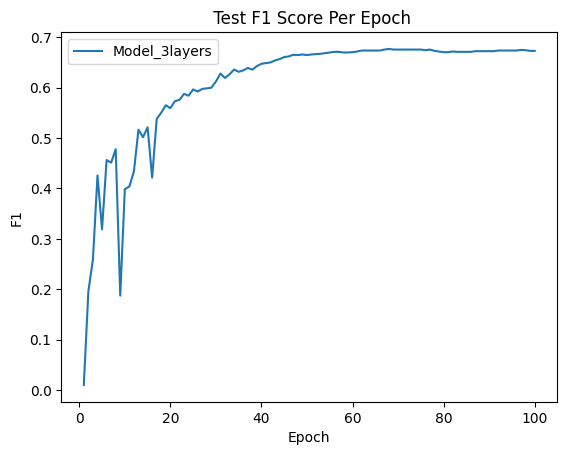

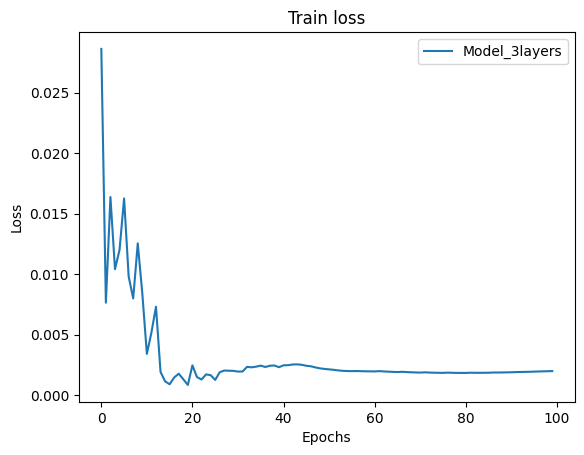

In [61]:
# Plot F1 & Losses:

f1s = [x[1] for x in stats]
losses = [x[0] for x in stats]

for s, label in zip(f1s, ["Model_3layers","model_2layers"]):
  plt.plot([x for x in range(1, len(s)+1)], s, label= label)
  plt.ylabel("F1")
  plt.xlabel("Epoch")
  plt.title(" Test F1 Score Per Epoch")
plt.legend()
plt.show()

for loss, label in zip(losses, [ "Model_3layers","model_2layers"]):
  plt.plot([x for x in range(len(loss))], [x for x in loss], label= label)
  plt.title("Train loss")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
plt.legend()
plt.show()

In [63]:
f1s

[[0.010016694490818032,
  0.19584569732937684,
  0.2591549295774648,
  0.4258373205741627,
  0.3189189189189188,
  0.4563445867287544,
  0.45123384253819043,
  0.477916194790487,
  0.18722139673105498,
  0.3984962406015038,
  0.4040404040404041,
  0.4340320591861899,
  0.5167037861915367,
  0.5016949152542373,
  0.5213483146067416,
  0.4214463840399002,
  0.538037486218302,
  0.5505617977528091,
  0.5652173913043479,
  0.5593784683684794,
  0.5732758620689655,
  0.5757575757575757,
  0.5877287405812701,
  0.5841476655808903,
  0.5965665236051502,
  0.5924324324324325,
  0.5976267529665589,
  0.5987124463519313,
  0.6000000000000001,
  0.6122881355932204,
  0.6280991735537189,
  0.6192468619246861,
  0.626680455015512,
  0.636085626911315,
  0.6315789473684211,
  0.6343434343434343,
  0.6391959798994975,
  0.6360000000000001,
  0.6427860696517412,
  0.6475247524752477,
  0.648862512363996,
  0.650197628458498,
  0.6541871921182265,
  0.656833824975418,
  0.6607843137254902,
  0.66210937

In [62]:
torch.save(model_3layers.state_dict(),'model_3layers.pt')  #<----- pickle model for future use

# Missing Data

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
# import os
# TRAIN_PATH = r"C:\Users\einam\Downloads\data\data\train"
# def load_all_patients(filename= "all_data.parquet" ,load_tsv=False):
#     if load_tsv:
#         df = pd.read_parquet(filename)
#         print(f">>> Total of {len(df['id'].unique())} patients files loaded successfully (from tsv file)")
#         return df

#     else:
#         all_files = os.listdir(TRAIN_PATH)
#         df_list = []
#         for f in all_files:
#             df = pd.read_csv(TRAIN_PATH + f"/{f}", sep="|")
#             df["id"] = f[:-4]  # add id column to each df
#             df_list.append(df)

#         print(f">>> Total of {len(df_list)} patients files loaded successfully")
#         return df_list



# if __name__ == '__main__':
#     df = load_all_patients(filename="all_data.parquet", load_tsv=True)
#     for col in df.columns:
#       col_mean = df[col].mean()
#       df[col].fillna(col_mean, inplace=True)
#     print(df)

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
# import os
# TRAIN_PATH = r"C:\Users\einam\Downloads\data\data\train"
# def load_all_patients(filename= "all_data.parquet" ,load_tsv=False):
#     if load_tsv:
#         df = pd.read_parquet(filename)
#         print(f">>> Total of {len(df['id'].unique())} patients files loaded successfully (from tsv file)")
#         return df

#     else:
#         all_files = os.listdir(TRAIN_PATH)
#         df_list = []
#         for f in all_files:
#             df = pd.read_csv(TRAIN_PATH + f"/{f}", sep="|")
#             df["id"] = f[:-4]  # add id column to each df
#             df_list.append(df)

#         print(f">>> Total of {len(df_list)} patients files loaded successfully")
#         return df_list



# if __name__ == '__main__':
#     df = load_all_patients(filename="all_data.parquet", load_tsv=True)
#     for col in df.columns:
#       col_count = df[col].isna().sum()
#       if col_count/len(df[col]) >= 0.5:
#         print(f"{col} count is {len(df[df[col].isna() & df['SepsisLabel'] == 1]['id'].unique())} ")
#         df.drop([col], axis =1, inplace=True)


In [ ]:
# for index, row in df.iterrows():
#   if(row['Temp'] is pd.na):
#     print(row['Temp'])
#   break


In [ ]:
# len(df[df['Calcium'].isna() & df['SepsisLabel'] == 1]['id'].unique())

In [ ]:
# df.to_parquet("df_mean_values.parquet")

In [ ]:
# df['HR'].mean()